# Pricing Test Data Challenge

## Goal
Pricing optimization is, non surprisingly, another area where data science can provide huge value.

The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

***

## Challenge Description

Company XYZ sells a software for `$39`. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (`$39`), while a random sample of 33% users a higher price (`$59`).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:
<li>
<b> Should the company sell its software for \\$39 or \\$59? </b>

<li>
The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. <b>What are your main findings looking at the data?</b>

<li>
[Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? <b>After how many days you would have stopped the test? Please, explain why.</b>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from numpy.random import seed
from scipy.stats import norm
from scipy.stats import t
import seaborn as sns

%matplotlib inline

In [2]:
# load and integrate data

test_results = pd.read_csv('test_results.csv')
user_table = pd.read_csv('user_table.csv')

In [3]:
data = test_results.merge(user_table, left_on = 'user_id',right_on = 'user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


### Data Wrangling and EDA

In [4]:
# modify timestamp values that exceeds 60 which is not accepted to be a valid datetime value. 
# Assuming modify 1-2 minute would not affect information
data['timestamp'] = data['timestamp'].apply(lambda x: x.replace(':60',':59'))

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275616 entries, 0 to 275615
Data columns (total 12 columns):
user_id             275616 non-null int64
timestamp           275616 non-null datetime64[ns]
source              275616 non-null object
device              275616 non-null object
operative_system    275616 non-null object
test                275616 non-null int64
price               275616 non-null int64
converted           275616 non-null int64
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 27.3+ MB


In [12]:
# check feature distribution, almost all features are catogorical.
# check unique values for each feature
for col in data.columns:
    print((col+":"),(len(data[col].unique())))

user_id: 275616
timestamp: 133542
source: 12
device: 2
operative_system: 6
test: 2
price: 2
converted: 2
city: 923
country: 1
lat: 713
long: 830


In [13]:
# only one country, this feature won't be considered
# too many value for city, therefore, explore the following features first: 
cat_columns = ['source', 'device', 'operative_system',  'country','price', 'converted']


### Check data randomness for each feature regarding two groups

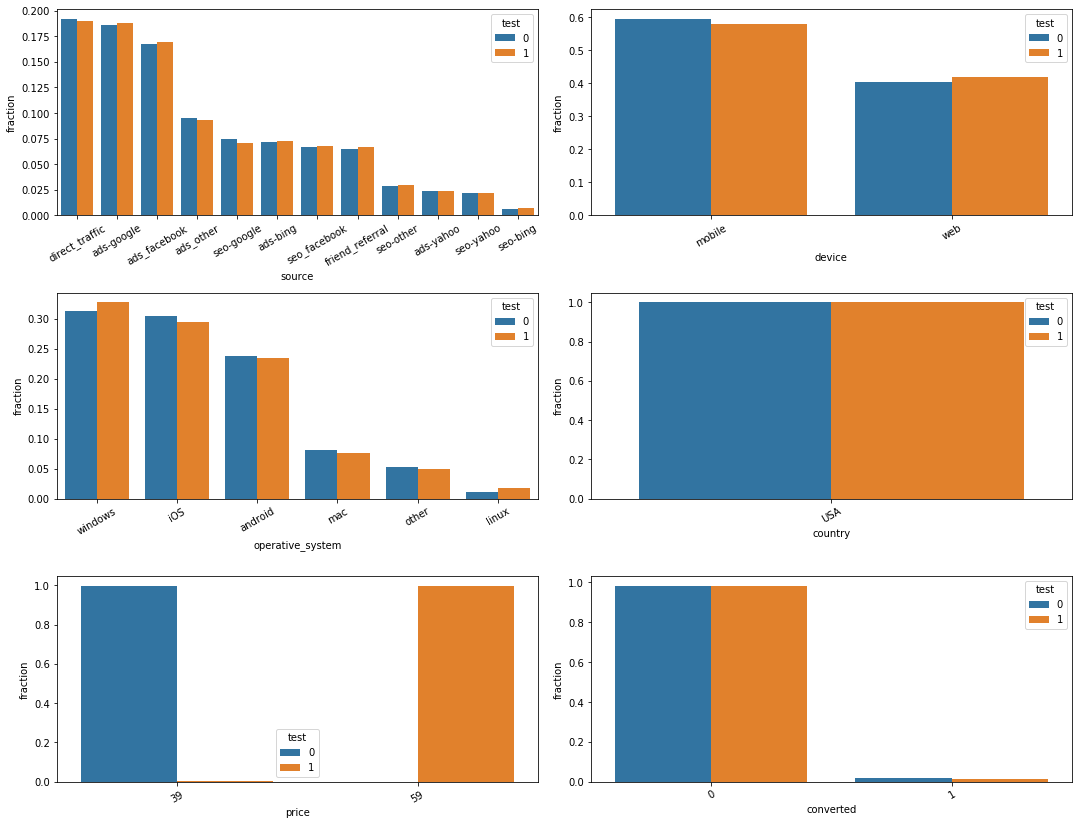

In [79]:
# plot value count for each categorical feature 
# using hue to see whether testing group has similar distribution pattern with control group

fig1 = plt.figure(figsize=(15,15))
i = 1
for col in cat_columns:
    ax = fig1.add_subplot(4,2,i)
    # get the normalized count for each category for two groups: contrl and test
    normed = data[col].groupby(data['test']).value_counts(normalize=True).round(4).rename('fraction').reset_index()
    sns.barplot(x=col,y='fraction',data=normed,hue='test',ax=ax)
    ax.set_xlabel(col)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=30)
    i += 1
plt.tight_layout()

In [72]:
# checking whether users are unique
len(data['user_id'].unique()), data.shape

(275616, (275616, 12))

### Findings from above:
<li>
    There is only contry: USA involved in the study, so no need to consider this feature. </li>
<li>
    Sample in both groups: test group and control group is randomly distributed, no obvious vialation in randomness.
</li>

In [8]:
# set time as index
df = data[['user_id', 'timestamp', 'source', 'device', 'operative_system', 'test',
       'price', 'converted', 'city']].set_index(data['timestamp'])

In [201]:
# split two groups

In [9]:
# check whether price match with testing group
from collections import Counter
Counter(zip(df['test'],df['price']))

Counter({(0, 39): 176241, (1, 59): 99053, (1, 39): 135, (0, 59): 187})

In [10]:
# drop the cases that price doesn't math with price
control = df.loc[(df['test']==0) & (df['price']==39)]
test = df.loc[(df['test']==1) & (df['price']==59)]

In [11]:
test.shape, control.shape

((99053, 9), (176241, 9))

In [18]:
control['converted'].sum(), test['converted'].sum()

(3484, 1530)

In [12]:
print("convertion rate in control group: {:.4}".format(control['converted'].sum()/control.shape[0]))
print("convertion rate in test group: {:.4}".format(test['converted'].sum()/test.shape[0]))

convertion rate in control group: 0.01977
convertion rate in test group: 0.01545


### Q1: Should the company sell its software for \$39 or \$59?
Eventhough increasing price lowered the convertion rate, but it increased profit 0.01977 * `$39` = 0.771 for control versus 0.01545 * `$59` = 0.911 for test since the price is higher and convertion rate didn't drop too much. Therefore, we need to add a correction factor to the test group with 59/39 = 0.51282, to correct the test conversion rate to 0.02337.


### Is the convertion rate difference statistically significant?
<li>
    Our null hypothesis is the test convertion rate is not better than the control rate. p_t <= p_c.
                                                                                                  
    we calculate z-score first

$$Z = \frac{p_t - p_c}{\sqrt{p_t(1-p_t)/N_t + p_c(1-p_c)/N_c}}$$

    The confidence interval of the convertion rate is (two tail, for one tail, only plus needed)

$$p { \scriptstyle\pm } Z_\alpha*SE $$

    while 
    
$$ SE = \sqrt{p(1-p)/N}$$

<br>
<li>
    We calculate sample size that required for one tail test to see a significant change. $\alpha$ is usually 0.05 and $\beta$ is usually 0.2
    
$$ N = \frac{(Z_\alpha + Z_{1-\beta})^2(p_t(1-p_t) + p_c(1-p_c))}{(p_t-p_c)^2}$$


In [4]:
def cal_z(p_t,p_c,Nt,Nc):
    """
    calcuate z-score
    p_t: test convertion rate
    p_c: control convertion rate
    Nt: test sample size
    Nc: control sample size
    """
    return (p_t - p_c)/np.sqrt((p_t*(1-p_t)/Nt) + (p_c*(1-p_c)/Nc))

def cal_n(Za,Z1_b,p_t,p_c):
    """
    calculate effective sample size at 
    type_I error = Za
    statistic power = 1 - type_II error = z1_b
    """
    return ((Za + Z1_b)**2)*(p_t*(1-p_t) + p_c*(1-p_c))/(p_t - p_c)**2

def cal_se(p,N):
    """
    calculate standard error
    """
    return np.sqrt(p*(1-p)/N)

### Z-test

In [5]:

p_t = 0.01545 # test convertion rate
correct = 59/39 # correction by price difference
p_c = 0.01977 # control convertion rate
p_t = p_t*correct # corrected test convertion rate

Nt = 99053 # sample size for test
Nc = 176241 # control sample size

Za = norm.ppf(0.95) # set alpha level = 0.05
Z1_b = norm.ppf(0.8) # statistic power = 0.8

margin = Za*cal_se(p_c,Nc) # margin of error
Z = cal_z(p_t,p_c,Nt,Nc) 
N = cal_n(Za,Z1_b,p_t,p_c)

In [6]:
# requried sample size, calculated z-score, and confidence interval for control
round(N,0),round(Z,4),(p_c,p_c+margin)

(20100.0, 6.1755, (0.01977, 0.020315432625754498))

In [19]:
# confidence interval for test and control
p_t + Za*cal_se(p_t,Nt), p_c+Za*cal_se(p_c,Nc)

(0.02416269254239871, 0.020315432625754498)

### Conclusion:
<li>The Z score is 6.1755, which is much higher than the $Z_{alpah0.05} = 1.645$,  Therefore, <b>the result is statistically significant</b>.</li>

<li>The confidence interval for control convertion rate is 0.01977 + margin = (0.01977, 0.02031), and the corrected conversion rate is 0.02337, which is higher than the right margin of the control, therefore, in another way, <b>the result is statistically significant</b>.

<li>Acutually, the sample size 99053 is much higher than required sample size to calculate significance, which is only 20100 needed, as calculated by above N.</li>

### Q2: Holistic view of user behavior

### Time series view for user activity

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 275616 entries, 2015-05-08 03:38:34 to 2015-03-08 17:12:33
Data columns (total 9 columns):
user_id             275616 non-null int64
timestamp           275616 non-null datetime64[ns]
source              275616 non-null object
device              275616 non-null object
operative_system    275616 non-null object
test                275616 non-null int64
price               275616 non-null int64
converted           275616 non-null int64
city                275616 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 21.0+ MB


### User activity along time

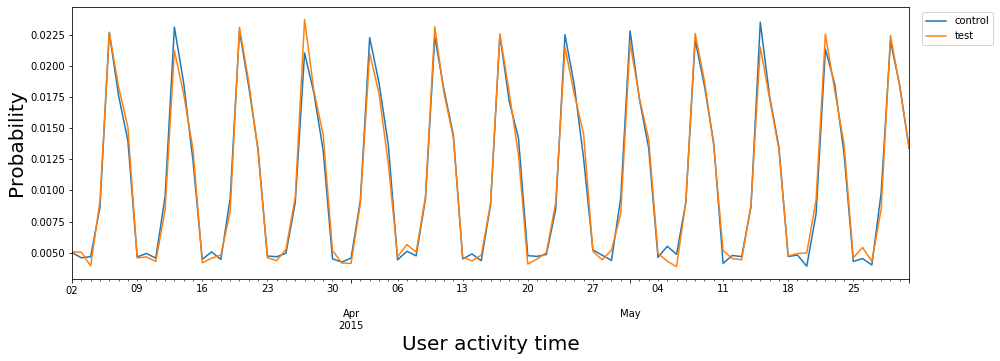

In [223]:
# over-all view in days
control_d = control.resample('1d')['user_id'].count()/Nc
test_d = test.resample('1d')['user_id'].count()/Nt

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))

Very periodical weekly pattern.

(23829120, 23849280)

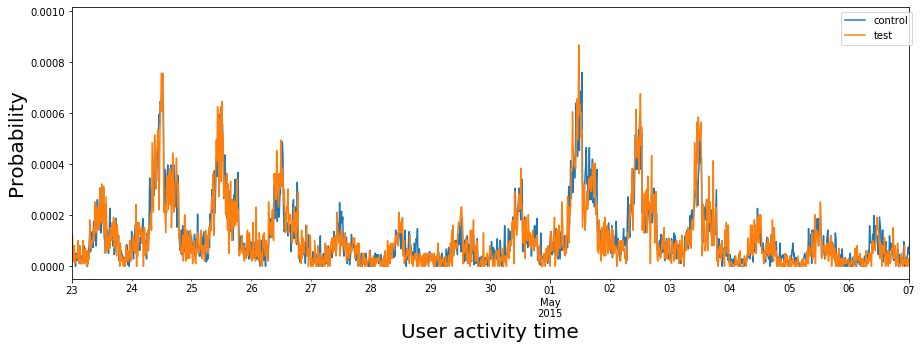

In [228]:
# over-all view within a day for 2 weeks
control_d = control.resample('15min')['user_id'].count()/Nc
test_d = test.resample('15min')['user_id'].count()/Nt

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlim(['2015-04-23','2015-05-07'])

Strong weekend peaks: Peak days are Friday(24,1), Saturday(25,2) and Sunday(26,3)

(23830560, 23833440)

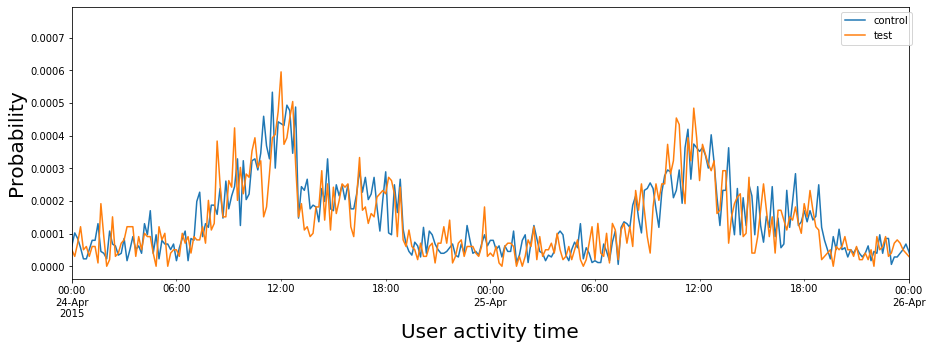

In [233]:
# over-all view within a day for 2 days during weekend
control_d = control.resample('10min')['user_id'].count()/Nc
test_d = test.resample('10min')['user_id'].count()/Nt

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlim(['2015-04-24','2015-04-26'])

peak at noon (12:00)

### Convertion rate over time

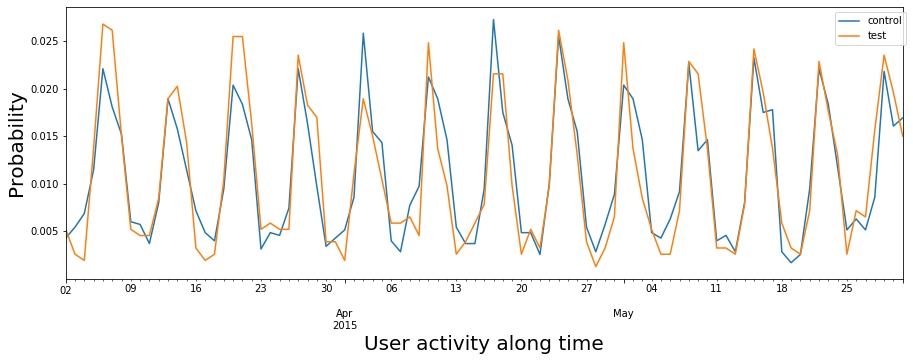

In [242]:
# over-all view in days
control_d = control.resample('1d')['converted'].sum()/(Nc*p_c) # normalized convertion probability for control
test_d = test.resample('1d')['converted'].sum()/(Nt*p_t)*correct # normalized and corrected convertion rate for test

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity along time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))

(23829120, 23849280)

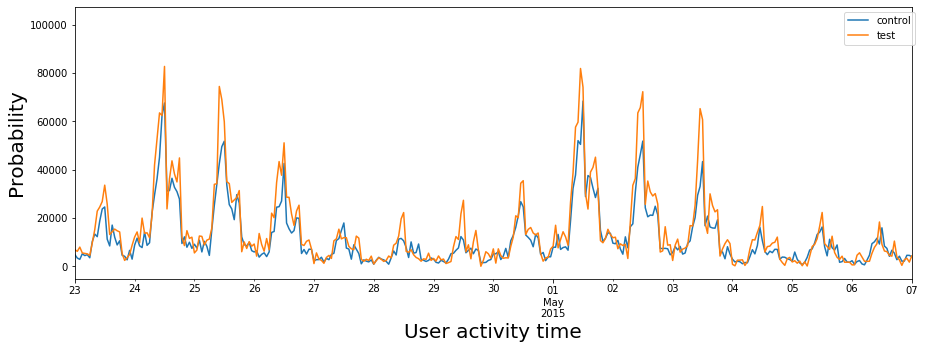

In [243]:
# over-all view within a day for 2 weeks
control_d = control.resample('60min')['user_id'].sum()/(Nc*p_c)
test_d = test.resample('60min')['user_id'].sum()/(Nt*p_t)*correct

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlim(['2015-04-23','2015-05-07'])

(23830560, 23833440)

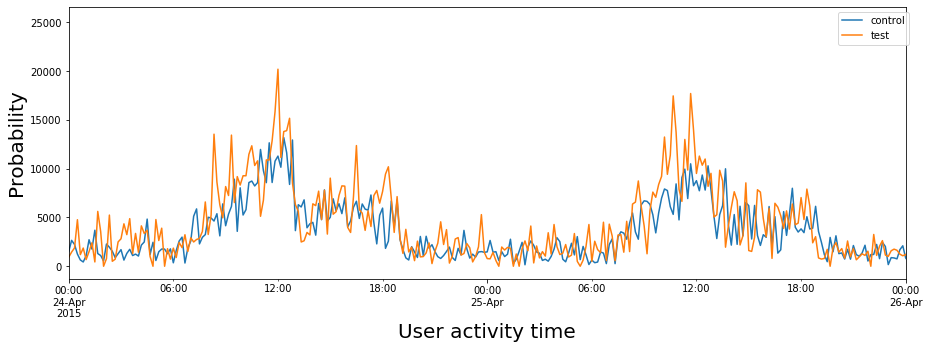

In [244]:
# over-all view within a day for 2 days during weekend
control_d = control.resample('10min')['user_id'].sum()/(Nc*p_c)
test_d = test.resample('10min')['user_id'].sum()/(Nt*p_t)*correct

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
control_d.plot(ax=ax, label='control')
test_d.plot(ax=ax,label='test')

plt.ylabel('Probability',fontsize=20)
plt.xlabel('User activity time', fontsize=20)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlim(['2015-04-24','2015-04-26'])

Strong correlation of convertion rate with user activity

### Convertion rate for each feature

In [82]:
columns = ['source', 'device', 'operative_system', 'city']

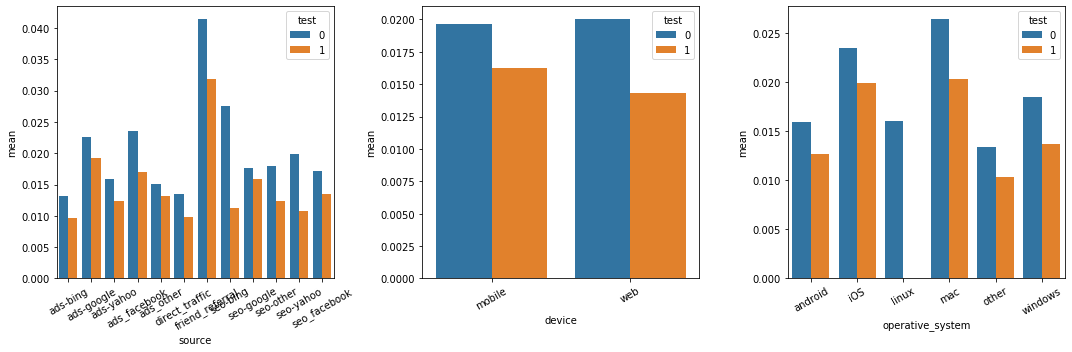

In [111]:
# plot convertion rate without correction
fig = plt.figure(figsize=(15,5))
i = 1
for col in columns[:-1]:
    ax = fig.add_subplot(1,3,i)
    
    mean = data.groupby(['test',col])['converted'].mean().rename('mean').reset_index()
    sns.barplot(x=col,y='mean',hue='test',data=mean,ax=ax)

    ax.set_xlabel(col)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=30)
    i += 1
plt.tight_layout()

In [116]:
# correct convertion rate for test group by adding (59/39 - 1) more to the convertion rate
add = 59/39 - 1 
data['corr'] = data['converted']*data['test']
data['corrected_convertion'] = data['corr']*add + data['converted']

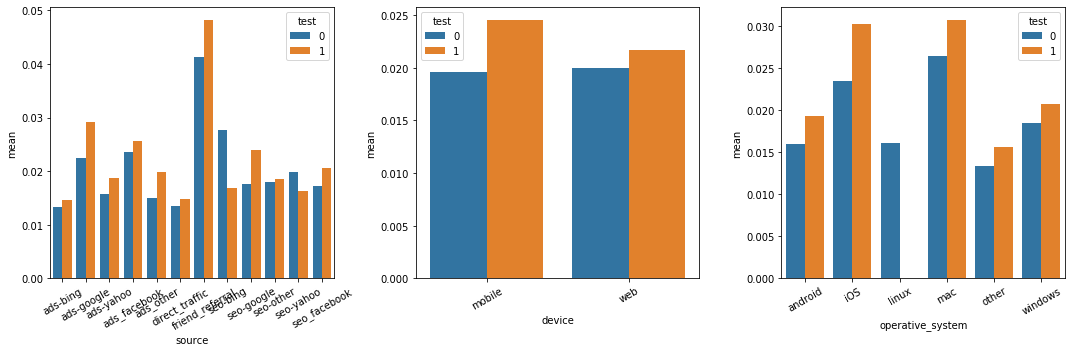

In [117]:
# plot convertion rate with correction

fig = plt.figure(figsize=(15,5))
i = 1
for col in columns[:-1]:
    ax = fig.add_subplot(1,3,i)
    
    mean = data.groupby(['test',col])['corrected_convertion'].mean().rename('mean').reset_index()
    sns.barplot(x=col,y='mean',hue='test',data=mean,ax=ax)

    ax.set_xlabel(col)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=30)
    i += 1
plt.tight_layout()

<b>Observation:</b>
<li>Friend_referral has highest convertion rate for both control and test as a source
<li>Mobile device get higher convertion rate in test than in control.
<li>iOS amd mac have higher convertion rate both in test and control.
<li>For most platforms, test has higher convertion rate than control, except for 'seo-bing' in 'source' feature and 'linux' in 'operative_system' feature.</li>

<b>Suggestion:</b>
<li> Change price from most sources except for 'seo-bing' and 'seo-yahoo'
<li> Change price on all operative-system except on 'linux'

In [124]:
df = data

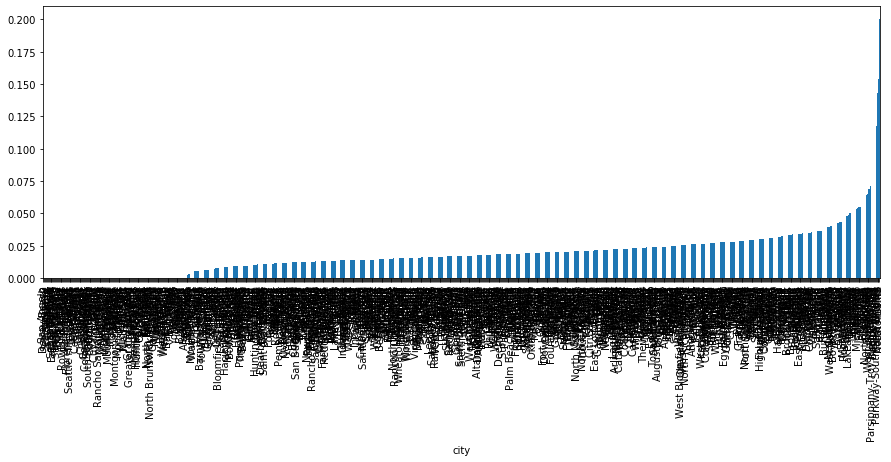

In [27]:
# plot city feature
fig,ax = plt.subplots(figsize=(15,5))
city_convert = df[['city', 'converted']].groupby('city').mean().sort_values(by='converted')
city_convert.plot(kind='bar',legend=False,ax=ax)

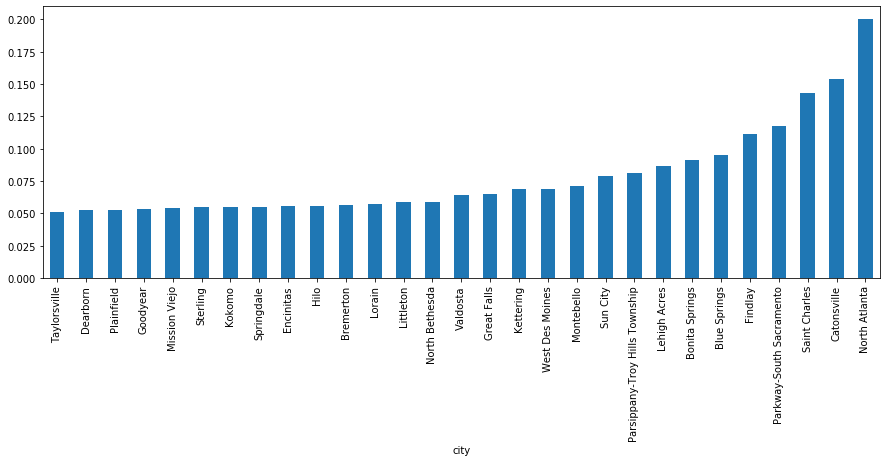

In [28]:
# too many cities, separate them into different buckets
# first buckets: high rates
fig,ax = plt.subplots(figsize=(15,5))
city_convert.loc[city_convert['converted'] > 0.05].plot(kind='bar',legend=False,ax=ax)

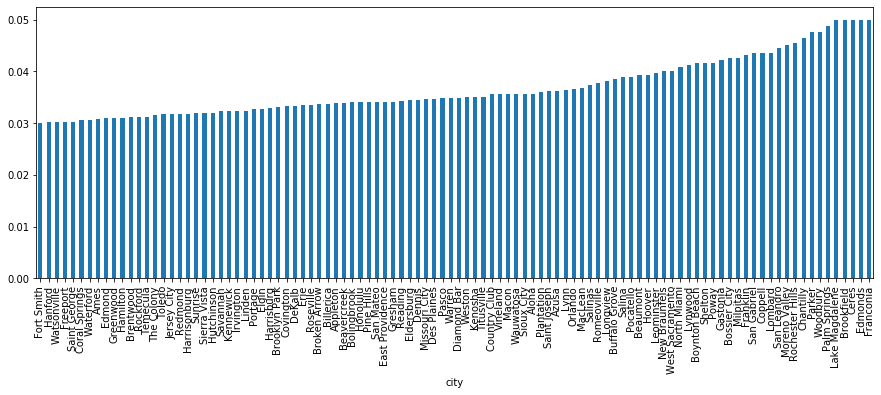

In [29]:
# second buckets: upper middle rate
fig,ax = plt.subplots(figsize=(15,5))
city_convert.loc[(city_convert['converted']>0.03) & (city_convert['converted']<=0.05)].plot(\
                                                                        kind='bar',legend=False,ax=ax)

In [122]:
# group cities to clusters according to geomatric distance

from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score

In [126]:
# we choose 50 clusters since there are 50 states in USA

km_cluster = KMeans(n_clusters=50).fit(df[['lat','long']])


In [127]:
df['cluster'] = km_cluster.labels_

In [128]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,corr,corrected_convertion,cluster
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0,0.0,18
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0,0.0,16
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0,0.0,31
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0,0.0,22
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0,0.0,27


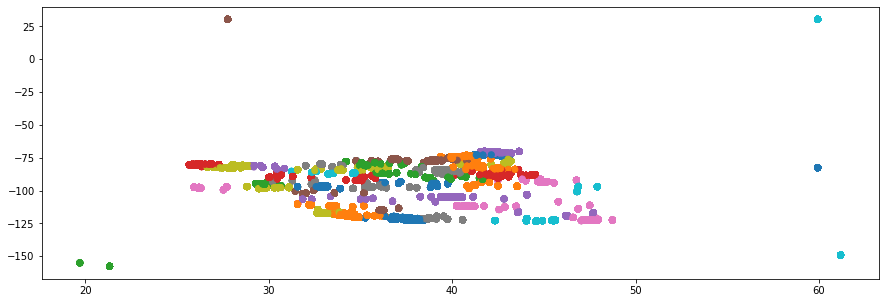

In [130]:
# 50 clusters
fig = plt.figure(figsize=(15,5))

color_seq = ['C'+str(i) for i in range(50)]
colors = df['cluster'].map(lambda x: color_seq[x])
plt.scatter(df['lat'],df['long'],c=colors)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


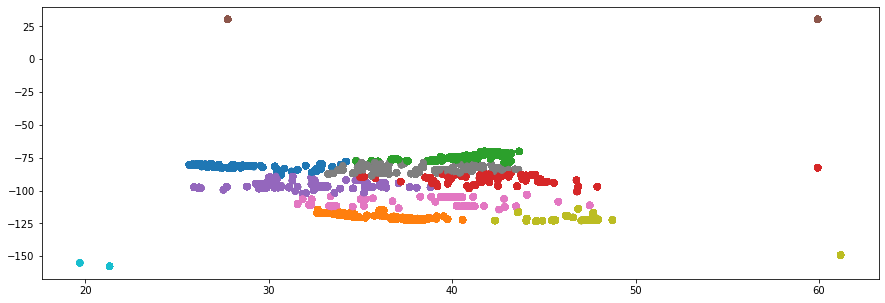

In [131]:
# 10 clusters
cities = df[['lat','long']]
fig = plt.figure(figsize=(15,5))
km_cluster = KMeans(n_clusters=10).fit(cities)
cities['cluster'] = km_cluster.labels_

color_seq = ['C'+str(i) for i in range(50)]
colors = cities['cluster'].map(lambda x: color_seq[x])
plt.scatter(cities['lat'],cities['long'],c=colors)

In [132]:
# drop the cases that price doesn't math with price
control = df.loc[(df['test']==0) & (df['price']==39)]
test = df.loc[(df['test']==1) & (df['price']==59)]

Text(0, 0.5, 'user activity probability')

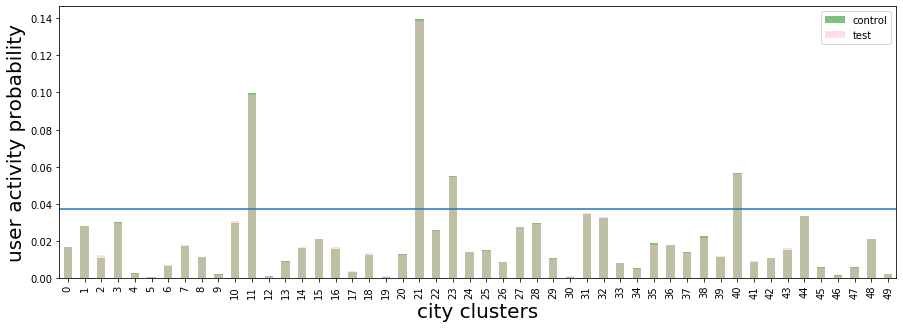

In [137]:
# user activity
col = 'cluster'

fig, ax = plt.subplots(figsize=(15,5))
control[[col, 'converted']].groupby(col).count().apply(lambda x: x/control.shape[0]).plot(kind='bar',ax=ax,\
                                                                            label='control',color='green',alpha=0.5)
test[[col, 'converted']].groupby(col).count().apply(lambda x: x/test.shape[0]).plot(kind='bar',ax=ax,\
                                                                        label='test',color='pink',alpha=0.5)
plt.legend(('control','test'))
plt.axhline(0.037)

plt.xlabel('city clusters',fontsize=20)
plt.ylabel('user activity probability',fontsize=20)

#### Observation
<li>Top 4 clusters: 11, 21, 23, 40 have the highest user activity</li>
<ol><ol>
        <li>cluster11: LA
        <li>cluster21: NY
        <li>cluster23: Chicago
        <li>cluster40: San Fransisco
    </ol>
    </ol>
<li>User activity is not different in two groups: test and control

In [140]:
# explore cities in these clusters
for i in [11,21,23,40]:
    print('cluster {}'.format(i))
    print(df.loc[df['cluster']==i].city.unique())

cluster 11
['Culver City' 'Redondo Beach' 'Garden Grove' 'Arcadia' 'Los Angeles'
 'Westminster' 'Riverside' 'Norwalk' 'Thousand Oaks' 'Colton'
 'San Bernardino' 'Inglewood' 'Pico Rivera' 'Anaheim' 'Pomona' 'Fullerton'
 'Huntington Park' 'Irvine' 'Newport Beach' 'Aliso Viejo'
 'Rancho Cucamonga' 'Lancaster' 'Fontana' 'Oxnard' 'Orange'
 'East Los Angeles' 'Huntington Beach' 'Long Beach' 'Santa Barbara'
 'Burbank' 'Torrance' 'Santa Ana' 'West Covina' 'Placentia' 'La Mirada'
 'El Monte' 'Santa Monica' 'Corona' 'Glendale' 'Chino Hills' 'Compton'
 'Highland' 'Hawthorne' 'Brea' 'Palmdale' 'Azusa' 'Covina' 'Chino'
 'Lake Forest' 'Alhambra' 'Pasadena' 'Fountain Valley' 'South Gate'
 'Ontario' 'South Whittier' 'Diamond Bar' 'Florence-Graham' 'Simi Valley'
 'Cypress' 'Bakersfield' 'Downey' 'Yorba Linda' 'Tulare' 'Rialto'
 'Buena Park' 'Victorville' 'Camarillo' 'Upland' 'La Puente' 'Altadena'
 'Lynwood' 'Carson' 'Bell Gardens' 'Rancho Palos Verdes' 'Lakewood'
 'Glendora' 'Delano' 'Lompoc' 'Visalia

Text(0, 0.5, 'user activity probability')

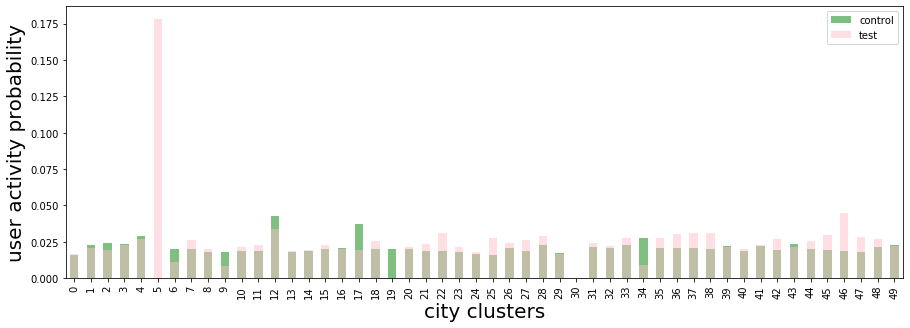

In [139]:
# plot convertion rate according to city clusters
fig,ax = plt.subplots(figsize=(15,5))

control[['cluster','converted']].groupby('cluster').mean().plot(kind='bar',ax=ax,label='control',\
                                                                color='green',alpha=0.5)
test[['cluster', 'converted']].groupby('cluster').mean().apply(lambda x: x*59/39).plot(kind='bar',ax=ax,\
                                                                                 label='test',color='pink',alpha=0.5)
plt.legend(('control','test'))
plt.xlabel('city clusters',fontsize=20)
plt.ylabel('user activity probability',fontsize=20)

<b> Observation: </b>
<li> Cluster 5 has the most convertion rate in test group (pink).
<li> Convertion rate in test group is generally higher in most clusters, for those which appear lower, should perform statistical test if needed to see whehter the difference is significant.</li>
    
<b> Suggestion: </b>

Change price. Unless further discovered significant drop of convertion rate in some of the cities after statistical analysis.


In [30]:
# Explore the cities in cluster 5
df.loc[df['cluster']==5].city.unique()

array(['Saint Petersburg'], dtype=object)

In [32]:
# explore cities in all clusters
for i in range(50):
    print('cluster {}'.format(i))
    print(df.loc[df['cluster']==i].city.unique())

cluster 0
['Culver City' 'Redondo Beach' 'Garden Grove' 'Arcadia' 'Los Angeles'
 'Westminster' 'Norwalk' 'Thousand Oaks' 'Inglewood' 'Pico Rivera'
 'Anaheim' 'Pomona' 'Fullerton' 'Huntington Park' 'Lancaster' 'Oxnard'
 'Orange' 'East Los Angeles' 'Huntington Beach' 'Long Beach'
 'Santa Barbara' 'Burbank' 'Torrance' 'Santa Ana' 'West Covina'
 'Placentia' 'La Mirada' 'El Monte' 'Santa Monica' 'Glendale'
 'Chino Hills' 'Compton' 'Hawthorne' 'Brea' 'Palmdale' 'Azusa' 'Covina'
 'Chino' 'Alhambra' 'Pasadena' 'Fountain Valley' 'South Gate'
 'South Whittier' 'Diamond Bar' 'Florence-Graham' 'Simi Valley' 'Cypress'
 'Bakersfield' 'Downey' 'Yorba Linda' 'Tulare' 'Buena Park' 'Camarillo'
 'Upland' 'La Puente' 'Altadena' 'Lynwood' 'Carson' 'Bell Gardens'
 'Rancho Palos Verdes' 'Lakewood' 'Glendora' 'Delano' 'Lompoc' 'Visalia'
 'Gardena' 'San Gabriel' 'Baldwin Park' 'Rosemead' 'Monterey Park'
 'Hacienda Heights' 'Paramount' 'Porterville' 'La Habra' 'Costa Mesa'
 'Rowland Heights' 'San Buenaventura' 

['Grand Rapids' 'Fort Wayne' 'Mishawaka' 'Lansing' 'Kalamazoo'
 'Battle Creek' 'Muskegon' 'South Bend' 'East Lansing' 'Elkhart'
 'Kentwood' 'Portage' 'Wyoming']
cluster 47
['Chesterfield' 'Saint Louis' 'Decatur' "O'Fallon" 'Springfield'
 'Florissant' 'Saint Peters' 'Normal' 'Peoria' 'Bloomington' 'Belleville'
 'Saint Charles']
cluster 48
['Milwaukee' 'Sheboygan' 'Green Bay' 'Oshkosh' 'Rockford' 'Appleton'
 'Brookfield' 'Janesville' 'Dubuque' 'Fond du Lac' 'Madison' 'Wauwatosa'
 'West Allis' 'Waukesha']
cluster 49
['Fargo' 'Grand Forks' 'Bismarck']


### A2: Holistic view of user behavior
Explored features:
timestamp  user_id,	source,	device,	operative_system,	test,	price,	converted,	city,	country,	lat,	long, cluster

<b>Observation: </b>
<li> Users are more active during weekends, most active during noon. Convertion events higher correlated with user activity.  </li>
<li> Apple sources have more activity and convertion rate. </li>
<li> Mobile deviced has higher convertion rate even with similar user activity. </li>
<li> top 4 regions in user activity: NY&NJ, SF, LA, Chicago. </li>
<li> convertion rate are similar accross cities, but 'Saint Petersburg' in Florida is specially higher. </li>

<b>Suggestions: </b>
<li> Change price</li>
<ol>
    
    But offer discount for linux users.
    Consider offer discount for users from 'seo-bing' and 'seo-yahoo'.
    Consider offer discount for some of the cities.

### Modeling for feature importance

In [119]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV


In [57]:
dfc = pd.concat([control,test])[['source','device','operative_system','converted','city','cluster']]

In [91]:
dfc.head()

,source,device,operative_system,converted,city,cluster
timestamp,,,,,,
2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,Buffalo,27
2015-05-10 21:08:46,seo-google,mobile,android,0,Lakeville,28
2015-04-04 15:01:23,ads-bing,mobile,android,0,Parma,44
2015-05-24 11:04:40,ads_facebook,web,mac,0,Fishers,9
2015-04-13 12:07:08,ads-google,mobile,iOS,0,New York,25


In [93]:
y = dfc['converted']
X = dfc.drop(columns='converted')

In [94]:
label_encoder = {}
for col in ['source','device','operative_system','city']:
    label_encoder[col] = {}
    label = 1
    for var in dfc[col].unique():
        label_encoder[col][var] = label
        label += 1
    X[col] = X[col].apply(lambda x: label_encoder[col][x])

In [95]:

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)

In [96]:
# upsampling Xtrain
Xyt = Xtrain.copy()
Xyt['y'] = ytrain

class0t = Xyt.loc[Xyt.y == 0]
class1t = Xyt.loc[Xyt.y == 1]

class1t = class1t.sample(n=class0t.shape[0],replace=True,random_state=0)
Xyt = pd.concat([class0t,class1t])
yt = Xyt['y'] # ytrain
Xt = Xyt.drop(columns=['y']) # Xtrain

In [85]:
param = {
    'max_depth': np.arange(5,20,5), # 5
    'n_estimators': np.arange(100,500,100), # 5
    'num_leaves': np.arange(500,2000,500), # 5
    'bagging_fraction': np.arange(0.1,1,0.1), # 10
    'learning_rate':np.arange(0.05,1,0.05), # 20
    'bagging_frequency': np.arange(0.1,1,0.2), # 5
    'colsample_bytree': np.arange(0.1,1,0.2), # 5
    'class_weight':np.arange(1,100,10)
}

In [109]:
random_search1 = RandomizedSearchCV(estimator=LGBMClassifier(class_weight={1:100}, categorical_features="0,1,2,3,4"),
                                    param_distributions=param,
                                    scoring='roc_auc',
                                    n_iter=40,
                                   cv = 4,
                                    n_jobs=6,
                                    verbose=1)
random_search1.fit(Xtrain,ytrain)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 160 out of 160 | elapsed: 11.5min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            categorical_features='0,1,2,3,4',
                                            class_weight={1: 100},
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=No...
                                        'colsample_bytree': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                                

In [110]:
model1 = random_search1.best_estimator_
model1

LGBMClassifier(bagging_fraction=0.2, bagging_frequency=0.7000000000000001,
               boosting_type='gbdt', categorical_features='0,1,2,3,4',
               class_weight={1: 100}, colsample_bytree=0.5000000000000001,
               importance_type='split', learning_rate=0.15000000000000002,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=400, n_jobs=-1, num_leaves=1500,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [112]:
roc_auc_score(ytest,model1.predict(Xtest)),roc_auc_score(ytrain,model1.predict(Xtrain))

(0.5395807928268845, 0.6406386619174307)

In [120]:
f1_score(ytest,model1.predict(Xtest)), f1_score(ytest,model.predict(Xtest))

(0.03894247945694891, 0.0377196127644317)

In [123]:
confusion_matrix(ytest,model1.predict(Xtest))


array([[16636, 37434],
       [  226,   763]])

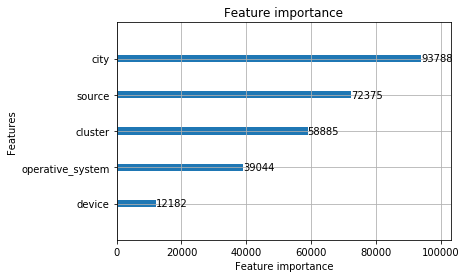

In [102]:
lgb.plot_importance(model)

### Q3: The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

#### A3: I agree with this intuition, as we shown in Q1, the sample size is much bigger than required. Now we will start the calculated along time when we could have stopped the test earlier

In [16]:
# sort data chronically
control = control.sort_index()
test = test.sort_index()

In [17]:
# assign cummulated count number to each date
control['count_a'] = [i+1 for i in range(control.shape[0])]
test['count_b'] = [i+1 for i in range(test.shape[0])]

In [18]:
control['cum_ca'] = control.converted.cumsum()
test['cum_cb'] = test.converted.cumsum()

In [19]:
# combine test and control and sort chronically
dfs = pd.concat([control,test])[['user_id','test','converted','cum_ca','cum_cb','count_a','count_b']]
dfs = dfs.sort_index()
dfs.head()

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,user_id,test,converted,cum_ca,cum_cb,count_a,count_b
timestamp,,,,,,,
2015-03-02 00:04:12,503836,1,0,NaN,0.0,NaN,1.0
2015-03-02 00:12:40,583796,0,0,0.0,NaN,1.0,NaN
2015-03-02 00:16:25,632922,0,0,0.0,NaN,2.0,NaN
2015-03-02 00:18:46,16110,0,0,0.0,NaN,3.0,NaN
2015-03-02 00:18:46,813542,0,0,0.0,NaN,4.0,NaN


In [24]:
def zscore(data):

    Nc = data['count_a']
    Nt = data['count_b']
    correct = 59/39
    p_c = data['cum_ca']/Nc
    p_t = data['cum_cb']/Nt*correct
    z = cal_z(p_t,p_c,Nt,Nc)

    return z
    

In [22]:
# fill cummulated count according to previous number (forward filling)
dfs = dfs.ffill()
dfs.head()

,user_id,test,converted,cum_ca,cum_cb,count_a,count_b
timestamp,,,,,,,
2015-03-02 00:04:12,503836,1,0,NaN,0.0,NaN,1.0
2015-03-02 00:12:40,583796,0,0,0.0,0.0,1.0,1.0
2015-03-02 00:16:25,632922,0,0,0.0,0.0,2.0,1.0
2015-03-02 00:18:46,16110,0,0,0.0,0.0,3.0,1.0
2015-03-02 00:18:46,813542,0,0,0.0,0.0,4.0,1.0


In [25]:
# calculate z_score for each data entry
from tqdm import tqdm
dfs['z_score'] = [zscore(dfs.iloc[i]) for i in range(dfs.shape[0])]

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [27]:
# check data/time range
dfs.index.min(),dfs.index.max()

(Timestamp('2015-03-02 00:04:12'), Timestamp('2015-05-31 23:59:45'))

In [28]:
# check the first qualified convertion start: with big enough Z-score (according to type_I error level) and 
# big enough sample size (according to type_II error level)
dfs.loc[(dfs['z_score']>Za) & (dfs['count_a']>N) & (dfs['count_b']>N)].head()

,user_id,test,converted,cum_ca,cum_cb,count_a,count_b,z_score
timestamp,,,,,,,,
2015-03-21 09:21:06,186381,1,0,713.0,335.0,36229.0,20101.0,4.175648
2015-03-21 09:21:06,164676,1,0,713.0,335.0,36229.0,20100.0,4.176452
2015-03-21 09:21:59,192752,1,0,713.0,335.0,36229.0,20102.0,4.174844
2015-03-21 09:22:11,238575,0,0,713.0,335.0,36231.0,20102.0,4.175733
2015-03-21 09:22:11,809303,0,0,713.0,335.0,36232.0,20102.0,4.176178


Text(2015-03-22, -1, 'end_time=2015-03-21')

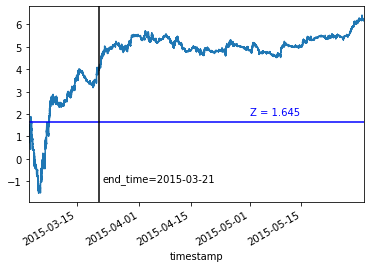

In [39]:
# plot z-score and sample size requirement over time
dfs['z_score'].plot()
plt.axhline(Za, color='b')
plt.axvline('2015-03-21',color='black')
plt.annotate('Z = 1.645', xy=('2015-05-01',Za+0.3), color='b')
plt.annotate('end_time=2015-03-21', xy=('2015-03-22',-1))

### The ealiest time point that the z_score is higher than required and with satisfied sample size start at 2015-03-21 9:21.